# Beer Classifier

----

## Importing Library

In [1]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import tables
import re
from math import ceil
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from random import shuffle
from tensorflow.contrib.layers import flatten

%matplotlib inline
np.random.seed(1)

/Users/peterhwang/anaconda/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/peterhwang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


## Creating Dictionary for label

In [5]:
label_dict = {}
beer_train_path = './training_dataset/train/*.jpg'
addrs = glob.glob(beer_train_path)

for addr in addrs:
    beer_label = re.search('\.\/training_dataset\/train\/(.*?)\.',addr).group(1)
    if label_dict.get(beer_label, None) == None:
        label_dict[beer_label] = int(len(label_dict))
        
print(label_dict)

{'goose_island_honkers_ale': 20, 'leffe_brune': 30, 'elysian_dayglow': 9, 'anchor_liberty_ale': 1, 'leffe_blonde': 29, 'kona_big_wave_golden_ale': 27, 'allagash_white': 0, 'michelob_ultra': 31, 'bluepoint_toasted_lager': 5, 'goose_island_four_star_pils': 19, 'founders_all_day_ipa': 12, 'elysian_superfuzz': 11, 'kona_longboard_island_lager': 28, 'stella_artois_cidre': 35, 'golden_road_wolf_pup_session_ipa': 17, 'hoegaarden': 25, 'sierra_nevada_pale_ale': 34, 'bells_hop_slam': 3, 'goose_island_312': 18, 'heineken': 24, 'bluepoint_hoptical_illusion': 4, 'founders_kbs': 13, 'samuel_adams_boston_lager': 33, 'modelo_especial': 32, 'golden_road_point_the_way_ipa': 15, 'stella_artois_lager': 36, 'stone_imperial_russian_stout': 37, 'elysian_spacedust': 10, 'kirin_ichiban': 26, 'goose_island_matilda': 22, 'corona_extra': 8, 'goose_island_sofie': 23, 'budweiser': 7, 'golden_road_tart_mango_cart': 16, 'balls_expedition': 2, 'goose_island_ipa': 21, 'golden_road_heal_the_bay_ipa': 14, 'brooklyn_lage

## Listing all images and lebeling them

In [6]:
shuffle_data = True
hdf5_path = './training_dataset/dataset8.hdf5'

labels = [label_dict[re.search('\.\/training_dataset\/train\/(.*?)\.',addr).group(1)] for addr in addrs]

if shuffle_data:
    c = list(zip(addrs, labels))
    shuffle(c)
    addrs, labels = zip(*c)
    
train_addrs = addrs[0:int(0.6*len(addrs))]
train_labels = labels[0:int(0.6*len(labels))]

val_addrs = addrs[int(0.6*len(addrs)):int(0.8*len(addrs))]
val_labels = labels[int(0.6*len(addrs)):int(0.8*len(addrs))]

test_addrs = addrs[int(0.8*len(addrs)):]
test_labels = labels[int(0.8*len(labels)):]

## Creating HDF5 file

In [4]:
data_order = 'tf'  # 'th' for Theano, 'tf' for Tensorflow
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved
# check the order of data and chose proper data shape to save images
if data_order == 'th':
    data_shape = (0, 3, 256, 256)
elif data_order == 'tf':
    data_shape = (0, 256, 256, 3)
# open a hdf5 file and create earrays
hdf5_file = tables.open_file(hdf5_path, mode='w')
train_storage = hdf5_file.create_earray(hdf5_file.root, 'train_img', img_dtype, shape=data_shape)
val_storage = hdf5_file.create_earray(hdf5_file.root, 'val_img', img_dtype, shape=data_shape)
test_storage = hdf5_file.create_earray(hdf5_file.root, 'test_img', img_dtype, shape=data_shape)
mean_storage = hdf5_file.create_earray(hdf5_file.root, 'train_mean', img_dtype, shape=data_shape)
# create the label arrays and copy the labels data in them
hdf5_file.create_array(hdf5_file.root, 'train_labels', train_labels)
hdf5_file.create_array(hdf5_file.root, 'val_labels', val_labels)
hdf5_file.create_array(hdf5_file.root, 'test_labels', test_labels)

/test_labels (Array(1072,)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'python'
  byteorder := 'little'
  chunkshape := None

## Loading images and saving them

In [5]:
# a numpy array to save the mean of the images
mean = np.zeros(data_shape[1:], np.float32)
# loop over train addresses
for i in range(len(train_addrs)):
    # print how many images are saved every 1000 images
    if i % 1000 == 0 and i > 1:
        print ('Train data: {}/{}'.format(i, len(train_addrs)))
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    addr = train_addrs[i]
    img = cv2.imread(addr)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # add any image pre-processing here
    # if the data order is Theano, axis orders should change
    if data_order == 'th':
        img = np.rollaxis(img, 2)
    # save the image and calculate the mean so far
    train_storage.append(img[None])
    mean += img / float(len(train_labels))
# loop over validation addresses
for i in range(len(val_addrs)):
    # print how many images are saved every 1000 images
    if i % 1000 == 0 and i > 1:
        print ('Validation data: {}/{}'.format(i, len(val_addrs)))
    # read an image and resize to (32, 32)
    # cv2 load images as BGR, convert it to RGB
    addr = val_addrs[i]
    img = cv2.imread(addr)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # add any image pre-processing here
    # if the data order is Theano, axis orders should change
    if data_order == 'th':
        img = np.rollaxis(img, 2)
    # save the image
    val_storage.append(img[None])
# loop over test addresses
for i in range(len(test_addrs)):
    # print how many images are saved every 1000 images
    if i % 1000 == 0 and i > 1:
        print ('Test data: {}/{}'.format(i, len(test_addrs)))
    # read an image and resize to (32, 32)
    # cv2 load images as BGR, convert it to RGB
    addr = test_addrs[i]
    img = cv2.imread(addr)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # add any image pre-processing here
    # if the data order is Theano, axis orders should change
    if data_order == 'th':
        img = np.rollaxis(img, 2)
    # save the image
    test_storage.append(img[None])
# save the mean and close the hdf5 file
mean_storage.append(mean[None])
hdf5_file.close()

Train data: 1000/3215
Train data: 2000/3215
Train data: 3000/3215
Validation data: 1000/1072
Test data: 1000/1072


## Reading the HDF5 File

In [7]:
subtract_mean = False
# open the hdf5 file
hdf5_file = tables.open_file(hdf5_path, mode='r')
# subtract the training mean
if subtract_mean:
    mm = hdf5_file.root.train_mean[0]
    mm = mm[np.newaxis, ...]
# Total number of samples
data_num = hdf5_file.root.train_img.shape[0]

1 / 85
23 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


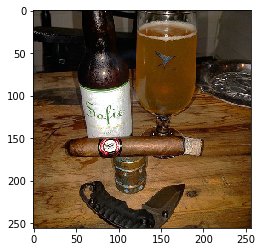

2 / 85
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


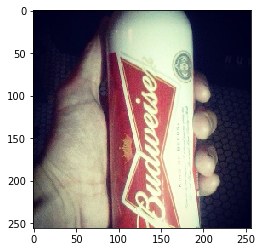

3 / 85
17 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


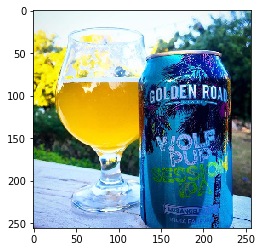

4 / 85
16 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


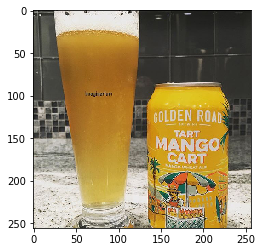

5 / 85
24 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


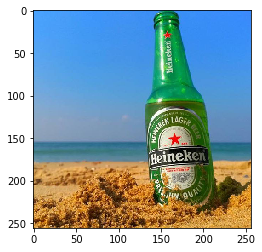

6 / 85
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


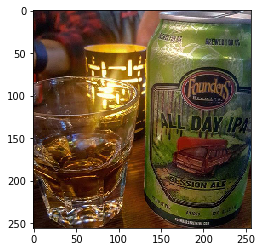

In [8]:
batch_size = int(38)
nb_class =int(38)
batches_list = list(range(int(ceil(float(data_num) / batch_size))))
shuffle(batches_list)
# loop over batches
for n, i in enumerate(batches_list):
    i_s = i * batch_size  # index of the first image in this batch
    i_e = min([(i + 1) * batch_size, data_num])  # index of the last image in this batch
    # read batch images and remove training mean
    images = hdf5_file.root.train_img[i_s:i_e]
    if subtract_mean:
        images -= mm
    # read labels and convert to one hot encoding
    labels = hdf5_file.root.train_labels[i_s:i_e]
    labels_one_hot = np.zeros((batch_size, nb_class))
    labels_one_hot[np.arange(batch_size), labels] = 1.
    print (n+1, '/', len(batches_list))
    print (labels[0], labels_one_hot[0, :])
    plt.imshow(images[0])
    plt.show()
    
    if n == 5:  # break after 5 batches
        break
hdf5_file.close()

## Loading dataset

In [9]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset()

## Example of a picture

y = 5


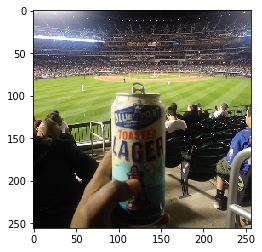

In [10]:
index = 1
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

## Flatten and normalize the image

In [11]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vector
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 38)
Y_test = convert_to_one_hot(Y_test_orig, 38)

print("number of training examples = " + str(X_train.shape[1]))
print("number of test examples = " + str(X_test.shape[1]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 3215
number of test examples = 1072
X_train shape: (196608, 3215)
Y_train shape: (38, 3215)
X_test shape: (196608, 1072)
Y_test shape: (38, 1072)


## Creating placeholder

In [12]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 224 * 224 * 3 = 150528)
    n_y -- scalar, number of classes (from 0 to 37, so -> 38)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    ### END CODE HERE ###
    
    return X, Y

In [13]:
X, Y = create_placeholders(196608, 38)
print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("X:0", shape=(196608, ?), dtype=float32)
Y = Tensor("Y:0", shape=(38, ?), dtype=float32)


## Initializing the parameters

In [14]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 150528]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [38, 12]
                        b3 : [38, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [25, 196608], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [38, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [38, 1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [15]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 196608) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


## Forward propagation in tensorflow

In [16]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [17]:

tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(196608, 38)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(38, ?), dtype=float32)


## Compute cost

In [18]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    ### END CODE HERE ###
    
    return cost

In [19]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(196608, 38)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

cost = Tensor("Mean:0", shape=(), dtype=float32)


## Model

In [22]:

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [ ]:
parameters = model(X_train, Y_train, X_test, Y_test)

Cost after epoch 0: 3.727990
